In [5]:
import io, os, sys, cv2, requests, time
import pandas as pd
from PIL import Image
from utils.camera import Camera
import torch
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms


In [6]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', "tbd ")
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !nvidia-smi
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION tbd 
__CUDNN VERSION: 8000
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [7]:
# load vgg16 model - may take a few minutes.
vgg16 = models.vgg16(pretrained=True)  

# load imagenet labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)  
labels = {int(key): value for key, value in response.json().items()}

In [8]:
# transform pipeline
def do_prediction(img):
    start_time= time.time()
    # min size as noted in the PyTorch pretrained models doc: 224 px
    min_img_size = 224  
    transform_pipeline = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    img_tensor = transform_pipeline(img)
    # print(type(img_tensor), img_tensor.shape)
    img_tensor = img_tensor.unsqueeze(0)  
    img_tensor = Variable(img_tensor)
    # print(type(img_tensor), img_tensor.shape)
    
    # returns a rensor of shape (batch, num class labels)
    prediction = vgg16(img_tensor)  

    # prediction will be the index of the class label with the largest value
    prediction_max = prediction.data.numpy().argmax()  
    # print(labels[prediction_max]) 

    # find labels of top predictions
    df = pd.DataFrame(data=prediction.data.numpy().reshape(-1)).nlargest(10, 0).reset_index()
    df.columns=['id', 'value']
    df['label'] = df['id'].apply(lambda x : labels[x])

    duration = time.time() - start_time
    
    return labels[prediction_max], df, duration

## predict image from internet
* power supply, 5 W : 4.2 sec
* power supply, MAX : 2.7 sec



In [9]:
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg'
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))  # Read bytes and store as an img

prediction, df, duration = do_prediction(img)
print(f'prediction: {prediction} - took {duration:.2f} seconds')
df.head()

prediction: Egyptian cat - took 4.69 seconds


,id,value,label
0,285,15.867176,Egyptian cat
1,282,11.985864,tiger cat
2,463,11.538254,"bucket, pail"
3,281,11.247927,"tabby, tabby cat"
4,287,11.227430,"lynx, catamount"


## predict image from file
* power supply, 5 W : 6.5 sec
* power supply, MAX : 4.1 sec


In [10]:
img = Image.open("images/dog.jpg")
prediction, df, duration = do_prediction(img)
print(f'prediction: {prediction} - took {duration:.2f} seconds')
df.head()

prediction: flat-coated retriever - took 6.38 seconds


,id,value,label
0,205,12.198810,flat-coated retriever
1,208,11.504194,Labrador retriever
2,805,9.540656,soccer ball
3,227,8.294345,kelpie
4,240,7.914511,Appenzeller


## predict image fom camera


In [12]:
camera0 = Camera(capture_device=0, width=224, height=224, 
                     capture_width=1280, capture_height=720, capture_fps=30, flip_mode=-1, debug=True)



nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=1280, height=720,                 format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv ! video/x-raw, width=(int)224,                 height=(int)224, format=(string)BGRx ! videoconvert ! appsink drop=true sync=false


In [13]:
img = camera0.get_image_rgb()
img = Image.fromarray(img, 'RGB')
prediction, df, duration = do_prediction(img)
print(f'prediction: {prediction} - took {duration:.2f} seconds')
df.head()

prediction: remote control, remote - took 5.65 seconds


,id,value,label
0,761,18.844080,"remote control, remote"
1,844,12.637836,"switch, electric switch, electrical switch"
2,673,12.530620,"mouse, computer mouse"
3,662,11.669402,modem
4,613,11.515938,joystick


## test camera

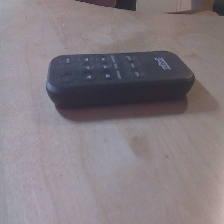

In [14]:
Image.fromarray(camera0.get_image_rgb(), 'RGB')